# Wrapping Libraries - Bagle Example

In this notebook we look at how users can add support for their own simulation packages by adding simple wrappers. The example covered in this notebook is the [Bagle Microlensing package](https://github.com/MovingUniverseLab/bagle_microlensing). To run this notebook you will need to install Bagle. See the instructions [here](https://bagle.readthedocs.io/en/latest/installation.html).

This notebook is based on the [lightcurvelynx_BAGLE.ipynb notebook](https://github.com/LSST-TVSSC/microlensing/blob/main/lightcurvelynx_simulations/lightcurvelynx_BAGLE.ipynb) by Natasha Abrams and Katarzyna Kruszynska (2025).


## Bagle

[Bagel](https://github.com/MovingUniverseLab/bagle_microlensing) is a package for simulating and analyzing gravitational lensing effects, which includes functions to model the output of such event. For an introduction to bagle, see their tutorial notebook: [https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb](https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb).

The core concept that we want to wrap in this example is the bagle model, which is a class that represents a microlensing event. The object's constructor takes in the parameters as (order dependent) arguments. For example, we can create a `PSPL_PhotAstrom_Par_Param1` (point source, point lens) object as:

In [ ]:
from bagle import model

# Create the event model with given parameter.
event1 = model.PSPL_PhotAstrom_Par_Param1(
    1.0,  # mL (msun)
    61600,  # t0 (MJD)
    0.1,  # beta (mas)
    4000.0,  # dL (pc)
    4000.0 / 8000.0,  # dL/dS
    0.0,  # xS0_E (mas/yr)
    0.0,  # xS0_N (mas/yr)
    5.0,  # muL_E (mas/yr)
    10.0,  # muL_N (mas/yr)
    0.0,  # muS_E (mas/yr)
    0.0,  # muS_N (mas/yr)
    [1, 1, 1, 1, 1, 1],  # b_sff
    [23, 22, 21.5, 21, 20.5, 19.5],  # mag_src
    raL=270.66679,  # RA (deg)
    decL=-35.70483,  # Dec (deg)
)

Given the model, we can query for terms such as the amplification level over given times. Here we use 200.0 days before the given t0 to 200.0 days after it.

Text(0, 0.5, 'Amplification')

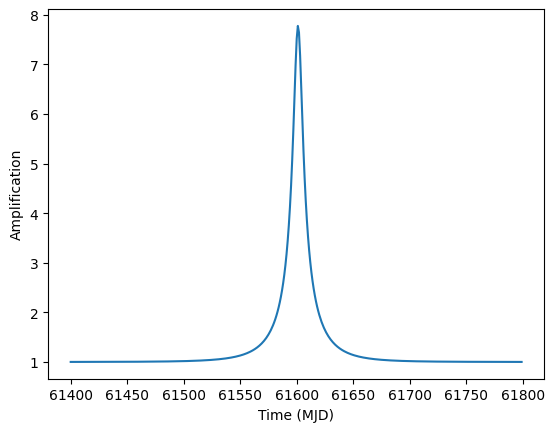

In [11]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(61400.0, 61800.0, 1.0)

A = event1.get_amplification(t)
plt.plot(t, A)
plt.xlabel("Time (MJD)")
plt.ylabel("Amplification")

## Wrapping Bagle Models

To wrap a bagle model we need to design a subclass of LightCurveLynx's `BasePhysicalModel` that: 1) constructs the bagle model, 2) sets its parameters, and 3) queries the flux that it produces. Since bagle models operate on the bandflux level, we start by subclassing LightCuvreLynx's `BandfluxModel` class.

We start using tan alternative approach for creating a model from the model name (given in Abrams and Kruszynska's notebook):

In [13]:
# Hard-coded coordinates of the event
model_name = "PSPL_PhotAstrom_Par_Param1"

dL = 4000  # Distance to lens
dS = 8000  # Distance to source
parameter_dict = {
    "raL": 270.66679,
    "decL": -35.70483,
    "mL": 1,  # Msun (Primary lens current mass)
    "t0": 61600,  # mjd
    "beta": 0.1,
    "dL": dL,
    "dL_dS": dL / dS,
    "xS0_E": 0.0,  # arbitrary offset (arcsec)
    "xS0_N": 0.0,  # arbitrary offset (arcsec)
    "muL_E": 5.0,
    "muL_N": 10.0,
    "muS_E": 0.0,
    "muS_N": 0.0,
    "b_sff": [1, 1, 1, 1, 1, 1],
    "mag_src": [23, 22, 21.5, 21, 20.5, 19.5],
}

# Create the model object, by creating the model class by name and passing the parameters as a dictionary.
mod_class = getattr(model, model_name)
mod = mod_class(**parameter_dict)

To wrap this as a LightCurveLynx model, we will need two functions:
* ``__init__()`` - Needs to set up the (settable) parameters.
* ``compute_bandflux()`` - Needs to compute the flux values at given times and filters.

The model above specifies the ``b_sff`` and ``mag_src`` for the filters in the order: u, g, r, i, z, y. To make the mappings easier, we define a class variable with dictionary mapping filter name to its index.

In [14]:
from lightcurvelynx.astro_utils.mag_flux import mag2flux
from lightcurvelynx.models.physical_model import BandfluxModel


class FixedBagelModel(BandfluxModel):
    """A wrapper for a Bagle model with a fixed set of parameters."""

    # Convenience mapping from filter name to index in the parameter list.
    _filter_idx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}

    def __init__(self, model_name, parameter_dict, **kwargs):
        # We start by extracting the parameter information needed for a general physical model.
        ra = parameter_dict["raL"]
        dec = parameter_dict["decL"]
        t0 = parameter_dict["t0"]

        # Call the parent class constructor to set up the model.
        super().__init__(ra=ra, dec=dec, t0=t0, **kwargs)

        # The create the bagle model object and set the parameters.
        self.model_name = model_name
        self.parameter_dict = parameter_dict
        mod_class = getattr(model, model_name)
        self.model_obj = mod_class(**parameter_dict)

    def compute_bandflux(self, times, filter, state):
        """Evaluate the model at the passband level for a single, given graph state and filter.

        Parameters
        ----------
        times : numpy.ndarray
            A length T array of observer frame timestamps in MJD.
        filter : str
            The name of the filter.
        state : GraphState
            An object mapping graph parameters to their values with num_samples=1.
            This is not used in this model, but is required for the function signature.

        Returns
        -------
        bandflux : numpy.ndarray
            A length T array of band fluxes for this model in this filter.
        """
        mags = self.model_obj.get_photometry(times, self._filter_idx[filter])
        bandflux = mag2flux(mags)
        return bandflux


# Create the source object.
source = FixedBagelModel(model_name, parameter_dict)

We can use the ``FixedBagelModel`` in the general LightCurveLynx simulation framework.

First, as always, we load the OpSim and filter information we want to use for the simulation.

In [5]:
from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.obstable.opsim import OpSim

opsim_db = OpSim.from_db(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")

table_dir = _LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)

Then we run the simulation. This is relatively fast because we are only evaluating the bagle model at the points where it is actually observed. In this case that means those times when Rubin's field of view included (270.66679, -35.70483).

In [15]:
from lightcurvelynx.simulate import simulate_lightcurves

lightcurves = simulate_lightcurves(source, 3, opsim_db, passband_group)

Simulating: 100%|██████████| 3/3 [00:00<00:00, 95.61obj/s]


And then we plot the results.

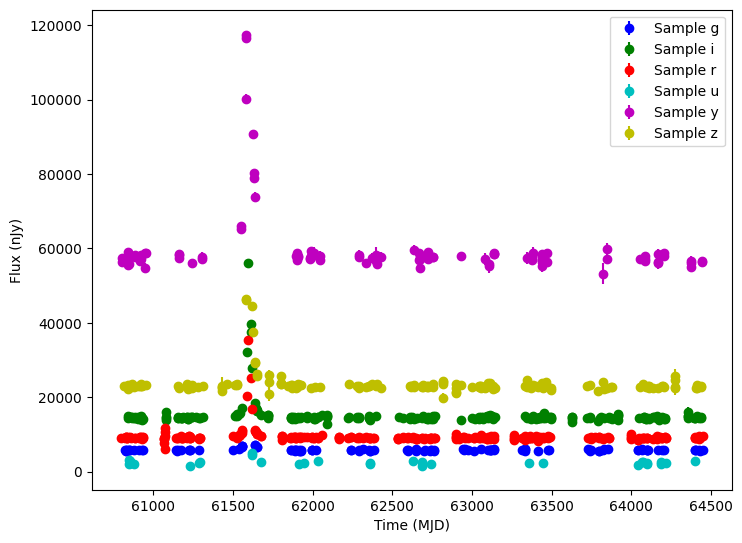

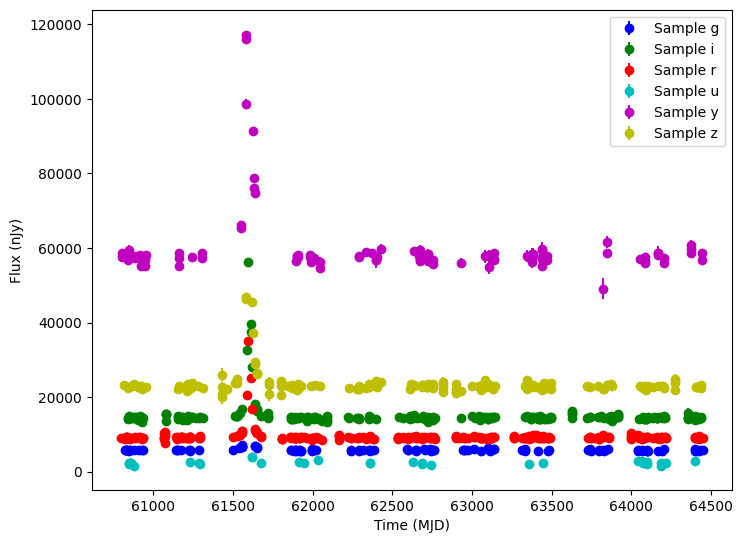

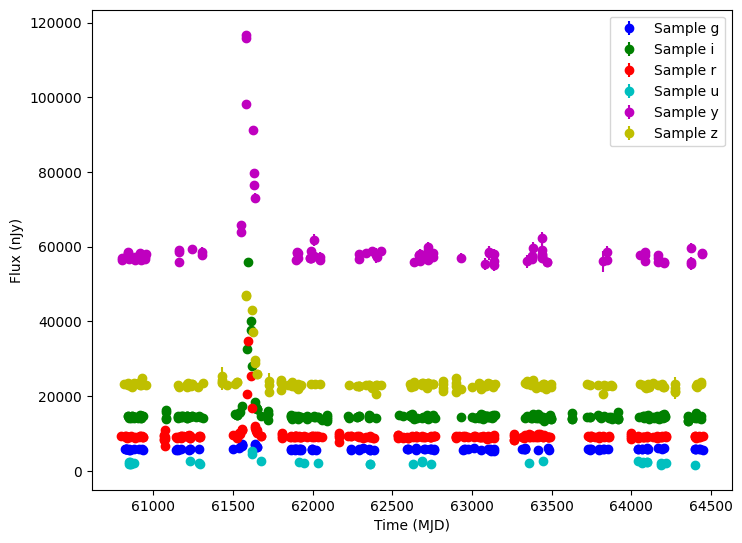

In [16]:
from lightcurvelynx.utils.plotting import plot_lightcurves

for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=np.asarray(lc["lightcurve"]["flux"], dtype=float),
        times=np.asarray(lc["lightcurve"]["mjd"], dtype=float),
        fluxerrs=np.asarray(lc["lightcurve"]["fluxerr"], dtype=float),
        filters=np.asarray(lc["lightcurve"]["filter"], dtype=str),
    )
    ax.legend()
    plt.show()

The **good news** is that the microlensing event shows up where expected (t0=61600). Unfortunately the **bad news** is that all three simulated events are identical, because we created the model using a fixed set of parameters.

## Adding LightCurveLynx Dynamic Sampling

We can make the LightCurveLynx wrapper more powerful by allowing the parameters to be set by the package’s sampling framework. As shown in other tutorial notebooks, parameters of a LightCurveLynx model can be set from a variety of sources, including constants or parameters from other nodes. In order to support a dynamic parameter, we use the ``add_parameter()`` function.

In [ ]:
class BagelModel(BandfluxModel):
    """A wrapper for a Bagle model with a flexible set of parameters."""

    # Convenience mapping from filter name to index in the parameter list.
    _filter_idx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}

    def __init__(self, model_name, parameter_dict, **kwargs):
        # We start by extracting the parameter information needed for a general physical model.
        ra = parameter_dict["raL"]
        dec = parameter_dict["decL"]
        t0 = parameter_dict["t0"]

        # Call the parent class constructor to set up the model.
        super().__init__(ra=ra, dec=dec, t0=t0, **kwargs)

        # Add all of the parameters in the dictionary as settable parameters,
        # and save their names (in order) for later use.
        self.parameter_names = []
        for param_name, param_value in parameter_dict.items():
            self.parameter_names.append(param_name)
            self.add_parameter(param_name, param_value)

        # Save the model name and class, but DO NOT create the model object yet.
        self.model_name = model_name
        self.model_class = getattr(model, model_name)

    def compute_bandflux(self, times, filter, state):
        """Evaluate the model at the passband level for a single, given graph state and filter.

        Parameters
        ----------
        times : numpy.ndarray
            A length T array of observer frame timestamps in MJD.
        filter : str
            The name of the filter.
        state : GraphState
            An object mapping graph parameters to their values with num_samples=1.
            This is not used in this model, but is required for the function signature.

        Returns
        -------
        bandflux : numpy.ndarray
            A length T array of band fluxes for this model in this filter.
        """
        # Create the bagle model object and set the parameters from the current state. We do this
        # here because the parameters saved in `state` will be different in each run.
        current_params = {param_name: state[param_name] for param_name in self.parameter_names}
        model_obj = self.model_class(**current_params)

        # Use the newly created model object with the current parameters to compute the photometry.
        mags = model_obj.get_photometry(times, self._filter_idx[filter])
        bandflux = mag2flux(mags)
        return bandflux

Let's expand out the parameter dictionary so some of the parameters are randomly chosen.

In [ ]:
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc

dL = 4000  # Distance to lens
dS = 8000  # Distance to source
parameter_dict2 = {
    "raL": 270.66679,
    "decL": -35.70483,
    "mL": 1,  # Msun (Primary lens current mass)
    "t0": NumpyRandomFunc("uniform", low=61500, high=61700),  # mjd
    "beta": 0.1,
    "dL": dL,
    "dL_dS": dL / dS,
    "xS0_E": 0.0,  # arbitrary offset (arcsec)
    "xS0_N": 0.0,  # arbitrary offset (arcsec)
    "muL_E": 5.0,
    "muL_N": 10.0,
    "muS_E": 0.0,
    "muS_N": 0.0,
    "b_sff": [1, 1, 1, 1, 1, 1],
    "mag_src": [23, 22, 21.5, 21, 20.5, 19.5],
}


# Create the source object.
source2 = BagelModel(model_name, parameter_dict)